# Discrete gamma hedging experiment for a European Call option under the BS model
Consider a market model with two assets, a Bank account and a Stock with $P$-dynamics

$$
dB(t) = rB(t) dt, \hspace{10mm} B(0) = 1 \\
dS(t) = \mu S(t) dt + \sigma S(t) dW(t), \hspace{10mm} S(0) = s > 0
$$

In our experiment we want to hedge a portfolio composed by an European call options that at time $T$ pays $X = (S(T) - K_1)^+$ where $K_1 > 0$ is the strike price. The pricing function of this call options is denoted with $F(t, s)$.

Since we cannot gamma hedge the call options with the underlying itself (the gamma of the underlying is zero) we are going to introduce another derivative in our hedging portfolio. For this purpose I've chosen a call options that at time $T_1 > T$ pays $Y = (S(T) - K_2)$, where $K_2 > K_1$ is the strike price of this options. The pricing function of this call options is denoted with $G(t, s)$. 

The experiment will be performed with the following parameters:
$$
S(0) = 100 \\
\mu = 0.0 \\
\sigma = 0.2 \\
K_1 = 110 \\
K_2 = 120 \\
T = 1.0 \\
T_1 = 1.1 \\
r = 0.0 
$$

Furthermore, no transaction costs will be assumed.

In [1]:
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import european_price, delta_european, gamma_european

In [2]:
seed = 0

In [3]:
s0 = 100.0
v0 = 0.2
mean = 0.0
kappa = 2.0
theta = 0.3
sigma = 0.3
rho = -0.6
discount_rate = 0.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)

In [4]:
K_1 = 110
K_2 = 120
maturity = 1.0
maturity_1 = 1.1
N = 252
dt = maturity / N
n_sim = 1000
dtype = jnp.float32

stock_paths = heston_model.sample_paths(seed, maturity, N, n_sim)

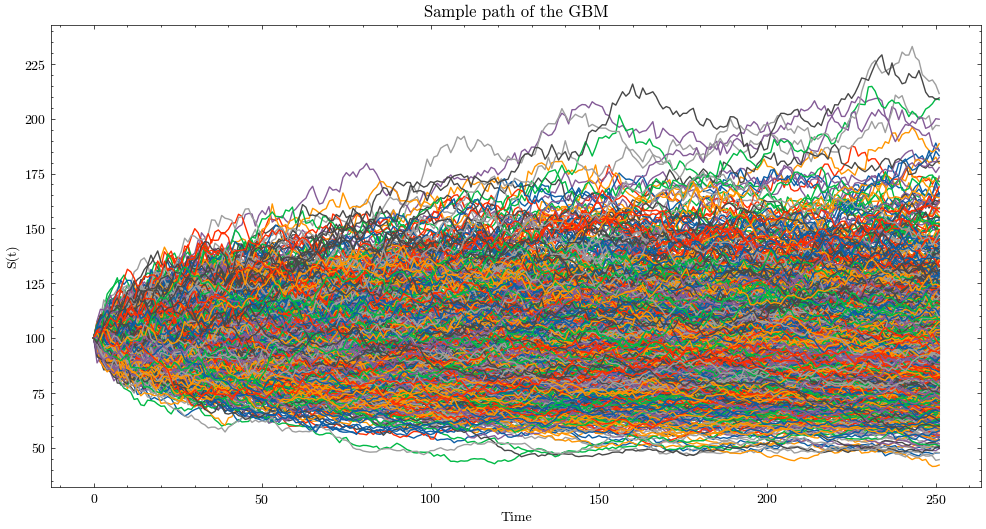

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(stock_paths)
plt.title('Sample path of the Heston')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.show()

## Hedging experiment code

The gamma hedging will be done in the following way (Bjork, ed 4th, Cp.10.3):

With the portfolio assuming the following form:

$$
\Pi_t = - V_t * \omega S_t + \omega_1 V_t^1
$$

we have that the discrete change of the value of the portfolio is

$$
\Delta \Pi_t = - \Delta V_t + \omega \Delta S_t + \omega_1 \Delta V_t^1 + r(\omega S_t - V_t + \omega_1 V_t^1) \Delta t
$$

Since we want to minimize the variance of $\Delta \Pi_t$ with respect to $\omega$, i.e

$$
\min_{\omega} \mathbb{V}[\Delta \Pi_t] 
$$


we obtain that the optimal weights are 

- $\omega_1 = \frac{\Gamma_t^V}{\Gamma_t^{V^1}}$
- $\omega = \frac{\Delta^{V^1} \Gamma_t^V}{\Gamma_t^{V^1}} - \Delta^V$


In [6]:
bs_sigma = theta

In [7]:
v_gamma_european = vmap(gamma_european, in_axes=(0, None, None, None, None))
v_delta_european = vmap(delta_european, in_axes=(0, None, None, None, None))

In [9]:
gammas_f = jnp.asarray([v_gamma_european(stock_paths[0], K_1, maturity - (i * dt), bs_sigma, discount_rate) for i in range(0, N)])
gammas_g = jnp.asarray([v_gamma_european(stock_paths[0], K_2, maturity_1 - (i * dt), bs_sigma, discount_rate) for i in range(0, N)])
x_g = jnp.full((N, n_sim), gammas_f[0] / gammas_g[0])
deltas_f = [v_delta_european(stock_paths[0], K_1, maturity - (i * dt), bs_sigma, discount_rate) for i in range(0, N)]
deltas_g = [v_delta_european(stock_paths[0], K_2, maturity_1 - (i * dt), bs_sigma, discount_rate) for i in range(0, N)]
x_s = [-((deltas_g[0] * gammas_f[0] / gammas_g[0]) - deltas_f[0])]
p_call_price = [european_price(stock_paths[i], K_1, maturity - (i * dt), bs_sigma, discount_rate) for i in range(0, N)]
h_call_price = [european_price(stock_paths[i], K_2, maturity_1 - (i * dt), bs_sigma, discount_rate) for i in range(0, N)]
bank_account = [p_call_price[0] - (x_g[0] * h_call_price[0] + x_s[0] * stock_paths[0])]
vs = [p_call_price[0]]
portfolio_delta = [0]

In [10]:
for i in range(1, N):
    vs.append(x_g[i - 1] * h_call_price[i] + x_s[i - 1] * stock_paths[i] + bank_account[i - 1])
    condition = ~((gammas_f[i, :] * 0.8 < gammas_g[i, :]) & (gammas_g[i, :] < gammas_f[i, :] * 1.2))
    x_g = x_g.at[i, :].set(jnp.where(condition, x_g[i-1, :], gammas_f[i, :] / gammas_g[i, :]))
    x_s.append(-((deltas_g[i] * x_g[i]) - deltas_f[i]))
    bank_account.append(vs[i] - (x_g[i] * h_call_price[i] + x_s[i] * stock_paths[i]))

hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K_1, 0)

In [31]:
print(f'The mean hedge error is: {jnp.nanmean(hedge_error[-1])}')
print(f'The (normalized) standard deviation is: {jnp.nanstd(hedge_error[-1]) / jnp.asarray(p_call_price)[0, 0]}')

The mean hedge error is: -0.09143099933862686
The (normalized) standard deviation is: 0.286048024892807


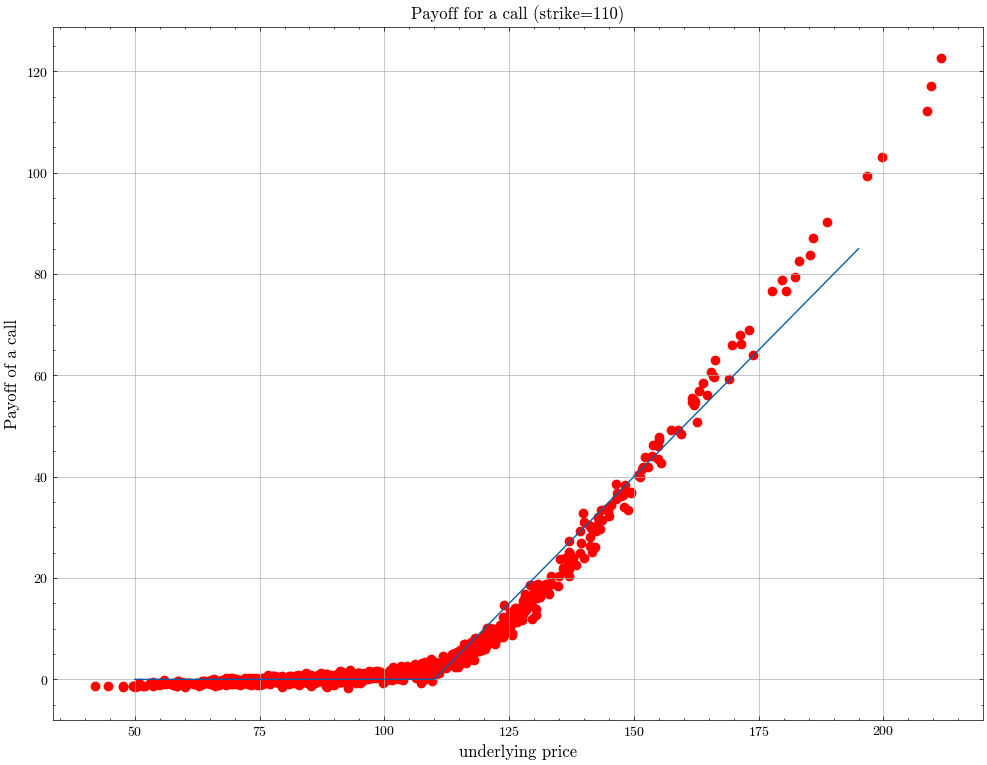

In [32]:
font = {'color':  'black',
        'weight': 'normal',
        'size': 12
       }

s = jnp.arange(50,200,5)
payoff= jnp.maximum(s - K_1, 0)
plt.figure(figsize=(12,9))
plt.plot(s,payoff)
plt.scatter(stock_paths[-1, :], jnp.asarray(vs)[-1, :], c='red')
plt.title(f"Payoff for a call (strike={K_1})", fontdict=font)
plt.xlabel("underlying price", fontdict=font)
plt.ylabel("Payoff of a call", fontdict=font)
plt.grid(True)
plt.show()